In [1]:
import os

import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

In [2]:
device0 = torch.device("cuda:0")
device1 = torch.device("cuda:1")

# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
# turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [3]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

In [8]:
sam2_checkpoint = "../models/SAM2/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device0, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

In [4]:
# Read the input image and convert to tensor (3, H, W) with RGB values normalized to [0, 1]
input_image = cv2.cvtColor(cv2.imread("../data/sample_images/image.png"), cv2.COLOR_BGR2RGB)                       
input_image_tensor = torch.tensor(input_image / 255, dtype=torch.float32, device=device0).permute(2, 0, 1)    
input_image_array  = np.array(input_image)

In [13]:
masks = mask_generator_2.generate(input_image_array)

/home/christopher/Documents/Code/segment-anything-2/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/home/christopher/Documents/Code/segment-anything-2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


In [21]:
import pickle
with open('masks.pkl', 'wb') as f:  # open a text file
    pickle.dump(masks, f) # serialize the list

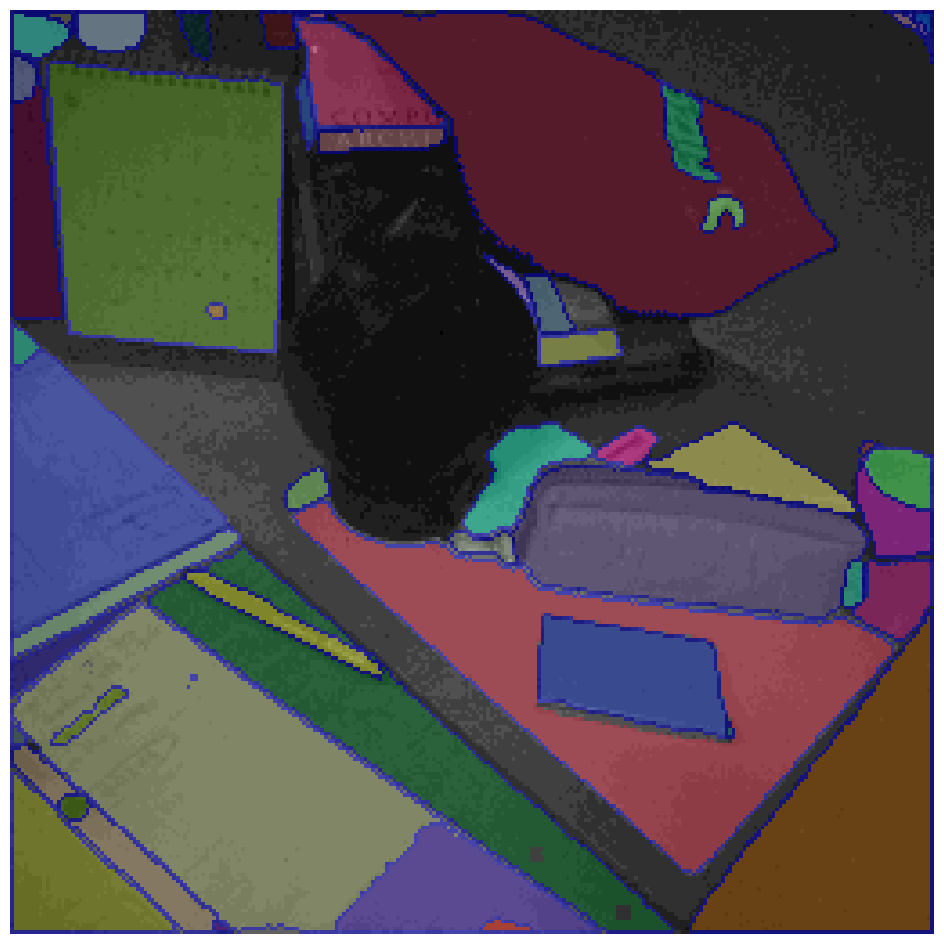

In [14]:
plt.figure(figsize=(12,12))
plt.imshow(input_image_array)
show_anns(masks)
plt.axis('off')
plt.show() 

In [3]:
import torch
import numpy as np
from torchvision.ops.boxes import batched_nms, box_area


# ──────────────────────────────────────────────────────────────────────────────
# 1.  SAM-2 INITIALISATION
# ──────────────────────────────────────────────────────────────────────────────
def setup_sam(sam_checkpoint: str, sam_cfg: str, device: str = "cuda"):
    """
    Build a SAM-2 model + image predictor.

    Parameters
    ----------
    sam_checkpoint : str
        Path to the *.pt* checkpoint (e.g. *sam2.1_hiera_large.pt*).
    sam_cfg : str
        Path to the corresponding YAML (e.g. *configs/sam2.1/sam2.1_hiera_l.yaml*).
    device : str
        "cuda" or "cpu".
    """
    from sam2.build_sam import build_sam2                   # :contentReference[oaicite:0]{index=0}
    from sam2.sam2_image_predictor import SAM2ImagePredictor  # :contentReference[oaicite:1]{index=1}

    model = build_sam2(config_file=sam_cfg,
                       ckpt_path=sam_checkpoint,
                       device=device,
                       mode="eval")
    return SAM2ImagePredictor(model)


# ──────────────────────────────────────────────────────────────────────────────
# 2.  SAM-2 INFERENCE FOR A BATCH OF PROMPT POINTS
# ──────────────────────────────────────────────────────────────────────────────
def infer_sam_masks_batch(predictor,
                          image: np.ndarray,
                          points: torch.Tensor,
                          logits: bool = True):
    """
    Generate SAM-2 masks for a batch of click prompts.

    Parameters
    ----------
    predictor : SAM2ImagePredictor
    image     : H×W×3 RGB uint8 array.
    points    : (N, 2) tensor in **pixel coordinates** (x, y).
    logits    : If True returns mask logits, else binary masks.
    """
    device = points.device
    predictor.set_image(image)                      # embedding done once

    masks_out, ious_out = [], []
    for p in points:                                # loop over prompts
        m, iou, _ = predictor.predict(
            point_coords=p.cpu().numpy()[None, :],  # shape (1, 2)
            point_labels=np.array([1], np.int32),   # 1 → foreground
            multimask_output=True,
            return_logits=logits,
            normalize_coords=True,                  # pixel → [0,1]
        )
        masks_out.append(torch.from_numpy(m).to(device))
        ious_out.append(torch.from_numpy(iou).to(device))

    masks = torch.stack(masks_out, 0)          # [N, 3, H, W]
    iou_pred = torch.stack(ious_out, 0)        # [N, 3]
    return {"masks": masks, "iou_pred": iou_pred}


# ──────────────────────────────────────────────────────────────────────────────
# 3.  ANCILLARY UTILITIES (unchanged except small bug‐fixes)
# ──────────────────────────────────────────────────────────────────────────────
def calculate_stability_score(masks, mask_thresh=0.0, offset=1.0):
    masks = masks.float()
    masks_bin = (masks > mask_thresh).float()
    masks_bin_offset = (masks > (mask_thresh + offset)).float()
    intersection = (masks_bin * masks_bin_offset).sum(dim=(-1, -2))
    union = (masks_bin + masks_bin_offset).clamp(0, 1).sum(dim=(-1, -2))
    return intersection / (union + 1e-6)


def batched_mask_to_box(masks):
    boxes = []
    for mask in masks:
        y, x = torch.where(mask)
        if len(y) == 0:
            boxes.append(torch.tensor([0, 0, 0, 0],
                        device=mask.device, dtype=torch.float32))
        else:
            boxes.append(torch.tensor([x.min(), y.min(), x.max(), y.max()],
                        device=mask.device, dtype=torch.float32))
    return torch.stack(boxes, 0)


# ──────────────────────────────────────────────────────────────────────────────
# 4.  MAIN ENTRY POINT
# ──────────────────────────────────────────────────────────────────────────────
def predict_sam_segmentations(
    image: np.ndarray,
    sam_checkpoint: str,
    sam_cfg: str,
    device: str = "cuda",
    num_pts: int = 300,
    iou_threshold: float = 0.88,
    stability_score_thresh: float = 0.95,
    select_smallest: bool = True,
    nms: bool = True,
    box_nms_thresh: float = 0.7,
    filter_by_box_size: bool = True,
):
    """
    Over-segmentation with SAM-2.

    Returns dict with keys:
    masks • boxes • iou_preds • keypoints
    """
    predictor = setup_sam(sam_checkpoint, sam_cfg, device)
    H, W, _ = image.shape

    # random click prompts in pixel space
    keypoints = torch.stack([
        torch.randint(0, W, (num_pts,), device=device),
        torch.randint(0, H, (num_pts,), device=device)
    ], 1).float()  # shape (N, 2)

    # run SAM-2
    masks_out = infer_sam_masks_batch(predictor, image, keypoints)
    masks = masks_out["masks"]          # [N, 3, H, W]
    iou_pred = masks_out["iou_pred"]    # [N, 3]

    # quality filtering
    good = iou_pred > iou_threshold
    stability = calculate_stability_score(masks)
    good &= stability >= stability_score_thresh

    masks_bin = masks > 0.0

    if select_smallest:
        sizes = masks_bin.sum((-1, -2))
        sizes[~good] = 1e9
        idx = sizes.argmin(1)
        sel_masks = masks_bin[torch.arange(num_pts), idx]
        sel_iou = iou_pred[torch.arange(num_pts), idx]
        sel_good = good[torch.arange(num_pts), idx]
        kp_ids = torch.arange(num_pts, device=device)
    else:
        N, K, Hm, Wm = masks_bin.shape
        sel_masks = masks_bin.reshape(N * K, Hm, Wm)
        sel_iou = iou_pred.reshape(-1)
        sel_good = good.reshape(-1)
        kp_ids = torch.arange(N, device=device).repeat_interleave(K)

    keep = sel_good
    sel_masks = sel_masks[keep]
    sel_iou = sel_iou[keep]
    keypoints_final = keypoints[kp_ids[keep]]

    boxes = batched_mask_to_box(sel_masks)

    if nms and len(boxes) > 0:
        scores = 1 / (box_area(boxes).float() + 1e-6) if filter_by_box_size else sel_iou
        keep_nms = batched_nms(boxes.float(), scores,
                               torch.zeros_like(boxes[:, 0]),
                               iou_threshold=box_nms_thresh)
        sel_masks = sel_masks[keep_nms]
        sel_iou = sel_iou[keep_nms]
        boxes = boxes[keep_nms]
        keypoints_final = keypoints_final[keep_nms]

    return {
        "masks": sel_masks,        # [M, H, W]
        "boxes": boxes,            # [M, 4]
        "iou_preds": sel_iou,      # [M]
        "keypoints": keypoints_final,
    }


In [4]:
# input_image_array = cv2.cvtColor(cv2.imread("../data/sample_images/cars.jpg"), cv2.COLOR_BGR2RGB)
input_image_array = cv2.cvtColor(cv2.imread("scene.png"), cv2.COLOR_BGR2RGB)

In [9]:
sam2_checkpoint = "../models/SAM2/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

result = predict_sam_segmentations(
    image=input_image_array,
    sam_checkpoint=sam2_checkpoint,
    sam_cfg=model_cfg,
    device=device0,
    num_pts=300,
)

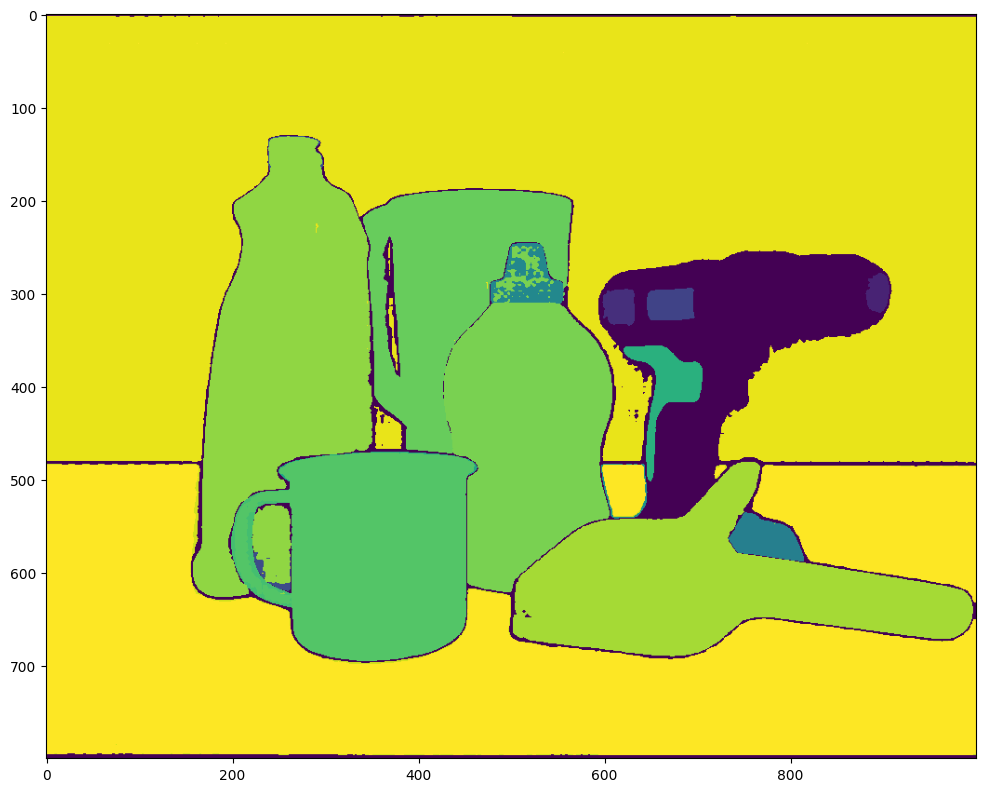

In [10]:
from superprimitive_fusion.utils import get_integer_segments
masks = result['masks'].cpu().numpy()
intseg = get_integer_segments(masks)

plt.figure(figsize=(12, 12))
plt.imshow(intseg)